## Hierarchical convolutional sparse coding with pacmen
(most of this code taken/adapted from [project](https://laurentperrinet.github.io/publication/franciosini-perrinet-19-neurofrance/), [github](https://arxiv.org/abs/2002.00892), [paper](https://arxiv.org/abs/2002.00892))

Recall that the original sparse coding energy function is

$$ \tag{1} E=\frac{1}{2}\sum_{x,y}\bigg[I(x,y) - \sum_i a_i \phi_i(x,y)\bigg]^2 + \lambda\sum_i C(a_i)$$

The model in this notebook is a 2-layer extension of sparse coding, with convolutional layers and feedback connections. The new energy function is (adapted from paper eq 2.5):

For layer 0:
$$ \tag{2} E^{(0)}=\frac{1}{2}\sum_{x,y}\bigg[I(x,y) - \sum_i a_i^{(0)} \phi_i(x,y)^{(0)}\bigg]^2 + \frac{1}{2}\sum_{x,y}\bigg[a_i^{(0)} - \sum_j a_j^{(1)} \phi_j(x,y)^{(1)}\bigg]^2 + \lambda^{(0)}\sum_i C(a_i^{(0)})$$

For layer 1:
$$ \tag{3} E^{(1)}=\frac{1}{2}\sum_{x,y}\bigg[a_i^{(0)} - \sum_j a_j^{(1)} \phi_j(x,y)^{(1)}\bigg]^2 + \lambda^{(1)}\sum_j C(a_j^{(1)})$$

Putting them together:
$$ \tag{4} E^{(0)}=\frac{1}{2}\sum_{x,y}\bigg[I(x,y) - \sum_i a_i^{(0)} \phi_i(x,y)^{(0)}\bigg]^2 + \sum_{x,y}\bigg[a_i^{(0)} - \sum_j a_j^{(1)} \phi_j(x,y)^{(1)}\bigg]^2 + \lambda^{(0)}\sum_i C(a_i^{(0)}) + \lambda^{(1)}\sum_j C(a_j^{(1)})$$




In [45]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from scipy.io import loadmat
from skimage import io
from tensorboardX import SummaryWriter
import torch
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from SDPC_PCB.Network import LayerPC, Network
from SDPC_PCB.Coding import ML_Lasso,ML_FISTA
from SDPC_PCB.DataTools import gaussian_kernel
from SDPC_PCB.Monitor import Monitor
from SDPC_PCB.Optimizers import mySGD, myAdam
from SDPC_PCB.DataTools import norm
from sparsecoding.data.transforms.patch import patchify

In [95]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.axis('off')
    return plt

def reconstruction(Net, gamma):
    reco = [None] * (Net.nb_layers)
    for i in range(Net.nb_layers-1, -1, -1):
        reco[i] = gamma[i]
        for j in range(i, -1, -1):
            reco[i] = Net.layers[j].backward(reco[i])
    return reco

class MyDataset(Dataset):
    """Dataset created by images from specified folder."""

    def __init__(self, root_dir, patch_size, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            patch_size (int): Length of one side of square patch.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.patch_size = patch_size
        self.transform = transform

    def __len__(self):
        return len(glob.glob(os.path.join(self.root_dir, "*.png")))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,"im_{}.png".format(idx))
        image = torch.Tensor(io.imread(img_name)).float()
        image = torch.permute(image, (2, 0, 1))
        image = image[0,:,:].unsqueeze(0)  # only one channel
        assert image.shape[-1] == self.patch_size

        if self.transform:
            image = self.transform(image)
        return image

### try training STL model on pacmen

In [96]:
# Load Bruno images, each batch is [batch_size, 1, 96, 96]
batch_size=25
dataset = MyDataset("/Users/galen/Synology/fall22_courses/265/IllusoryContours/pacmen", patch_size=96)
database = DataLoader(dataset, batch_size=25, shuffle=True, drop_last=True)
input_size = list(next(iter(database)).shape)
print("data batch size: {}".format(input_size))

## Setting parameters
dict_sizes = [(64,1,8,8), (128,64,8,8)] # [Layer 1, Layer 2]
l_r = [1e-4,5e-3]#### dictionaries learning rate [Layer1, Layer2] 
l_rv = [1e-3,1e-3]#### normalizer learning rate [Layer1, Layer2]
l = [0.4,1.6]#### Sparsity parameters [Layer1, Layer2]
b=1 #### Feedback strength parameter. b=0 --> Hila, b=1 --> 2L-SPC
v_i=[10,10] #### Initial normalizer value [Layer1, Layer2]
nb_epoch = 2 #### number of training epochs
Use_tb = True #### Use to activate tensorboard monitoring
save = True #### Use to run the entire simulation : TAKE HOURS. Use False to load previous simulation

## Gaussian masks for the dictionaries
mask_g = [gaussian_kernel(dict_sizes[0], sigma=30), gaussian_kernel(dict_sizes[1], sigma=30)]  # not sure why do this

[25, 1, 96, 96]


In [97]:
## Definition of the layers, network and sparse coding algorithm
layer = [LayerPC(dict_sizes[0], stride=2, b=b, v=v_i[0], v_size=64 ,out_pad=0),
        LayerPC(dict_sizes[1], stride=1, b=b, v=v_i[1], v_size=128 ,out_pad=0)]

Net = Network(layer, input_size=input_size)
Loss = ML_Lasso(Net, [l[0],l[1]])
# Pursuit = ML_FISTA(Net, Loss, max_iter=1000, th=1e-4, mode='eigen')
Pursuit = ML_FISTA(Net, Loss, max_iter=10, th=1e-4, mode='eigen')

## Optimizer initialization
opt_dico = [None] * (Net.nb_layers + 1)
for i in range(0, Net.nb_layers):
    opt_dico[i] = mySGD([{'params': Net.layers[i].dico}], lr=l_r[i], momentum=0.9, normalize=True)

opt_v = [myAdam([{'params': Net.layers[i].v}], lr=l_rv[i], normalize=False) \
    for i in range(Net.nb_layers)]

L = [None] * (Net.nb_layers)
L_v = [None] * (Net.nb_layers)
reco = [None] * (Net.nb_layers)

model_name = "pacmen_[{0},{1}]_b={2}".format(l[0],l[1],b)
model_path = os.path.join("Savings/pacmen", model_name+".pkl")
if Use_tb : 
    nrows = [8,8,8,8,8,8,8]
    writer = SummaryWriter('Savings/Log/' + model_name)
    M = Monitor(Net, writer, n_row=nrows)

k=0

l2_loss = torch.zeros(2,nb_epoch*len(database))
l1_loss = torch.zeros(2,nb_epoch*len(database))
for e in range(nb_epoch):
    for idx_batch, data in enumerate(database):
        print(idx_batch)
        if idx_batch == 5:  # need to somehow limit the number of times databse can be enumerated
            break

        # batch = data[0].cuda()
        batch = data
        gamma, it, Loss_G, delta = Pursuit.coding(batch)

        for i in range(Net.nb_layers):
            Net.layers[i].dico.requires_grad = True
            L[i] = Loss.F(batch, gamma, i, do_feedback=False).div(batch.size()[0])  ## Unsupervised
            L[i].backward()
            Net.layers[i].dico.requires_grad = False
            opt_dico[i].step()
            opt_dico[i].zero_grad()

            ##Mask
            Net.layers[i].dico*=mask_g[i]
            Net.layers[i].dico/=norm(Net.layers[i].dico)
            
            l2_loss[i,k]= L[i].detach() 
            l1_loss[i,k] =  gamma[i].detach().sum().div(gamma[i].size(0))
            

        for i in range(Net.nb_layers):
            Net.layers[i].v.requires_grad = True  # turn_on(i)
            L_v[i] = Loss.F_v(batch, gamma, i).div(batch.size()[0])
            L_v[i].backward()
            Net.layers[i].v.requires_grad = False  # turn_off(i)
            opt_v[i].step()  
            opt_v[i].zero_grad()
            
        if Use_tb:
            if (k%10) == 0:
                writer.add_scalar('FISTA_iterations', it, k)
                M.MonitorGamma(gamma, k, option=['NNZ', '%', 'Sum', 'V'])
                M.MonitorList(L, 'Loss_Dico', k)
                M.MonitorList(L_v, 'Loss_v', k)
                M.MonitorDicoBP(k)
                M.ComputeHisto(gamma)

            if (k%100) == 0:
                reco = [None] * (Net.nb_layers)
                for i in range(Net.nb_layers-1,-1,-1):
                    reco[i] = gamma[i]
                    for j in range(i, -1, -1):
                        reco[i] = Net.layers[j].backward(reco[i])
                    reco_image = make_grid(reco[i],normalize=True,pad_value=1)
                    writer.add_image('Reco/L{0}'.format(i),reco_image,k)

        k += 1

output_exp = {'Net': Net,
        'Loss': Loss,
        'Pursuit': Pursuit,
        'l2_loss': l2_loss,
        'l1_loss': l1_loss    
                }
with open(model_path, 'wb') as file:
    pickle.dump(output_exp, file, pickle.HIGHEST_PROTOCOL)

NETWORK STRUCTURE : 
 Input : [25, 1, 96, 96]
 Layer 1 : [25, 64, 45, 45]
 Layer 2 : [25, 128, 38, 38]
0


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


0


100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


In [98]:
%%time

Pursuit.max_iter = 10

# nb_image = 20*20
nb_image = batch_size
# all_batch = torch.zeros(nb_image,3,96,96).cuda()
# save_gamma_0 = torch.zeros(nb_image,64,45,45).cuda()
# save_gamma_1 = torch.zeros(nb_image,128,38,38).cuda()
all_batch = torch.zeros(nb_image, 3, 96, 96)
save_gamma_0 = torch.zeros(nb_image, 64, 45, 45)  # do we have to change this?
save_gamma_1 = torch.zeros(nb_image, 128, 38, 38)
k = 0

all_batch[k:k+data.size(0), :, :, :] = data
gamma, it, Loss_G, delta = Pursuit.coding(data)
print("done coding batch")

save_gamma_0 = gamma[0][:, :, :, :]
save_gamma_1 = gamma[1][:, :, :, :]


100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


done coding batch
CPU times: user 38.1 s, sys: 225 ms, total: 38.3 s
Wall time: 37.4 s


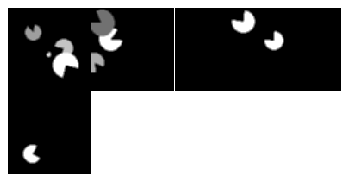

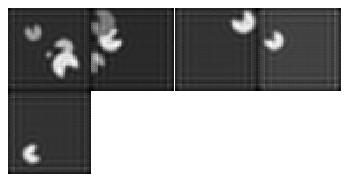

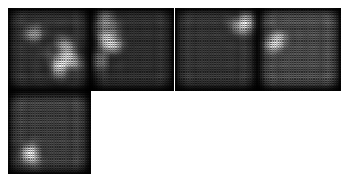

In [99]:
selected_img = [0,1,2,3,4]
gamma_n = [save_gamma_0[selected_img,:,:,:],save_gamma_1[selected_img,:,:,:]]
reco = reconstruction(Net,gamma_n)

save_fig = False

## Display input_data
grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':4, 'scale_each':True}
img2 = show(make_grid(all_batch[selected_img,:,:,:].cpu(),**grid_param))
img2.show()
if save_fig :
    save_image(make_grid(reco[0][:,:,:,:].cpu(), **grid_param), path_saving + '/Fig2/Fig2a.png')

    
## Display fist layer reconstruction
grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':4, 'scale_each':True}
img2 = show(make_grid(reco[0][:,:,:,:].cpu(),**grid_param))
img2.show()
if save_fig :
    save_image(make_grid(reco[0][:,:,:,:].cpu(), **grid_param), path_saving + '/Fig2/Fig2c.png')

## Display second layer reconstruction
grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':4, 'scale_each':True}
img2 = show(make_grid(reco[1][:,:,:,:].cpu(),**grid_param))
img2.show()
if save_fig :
    save_image(make_grid(reco[1][:,:,:,:].cpu(), **grid_param), path_saving +'/Fig2/Fig2e.png')

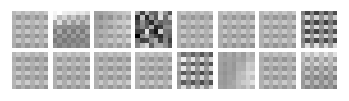

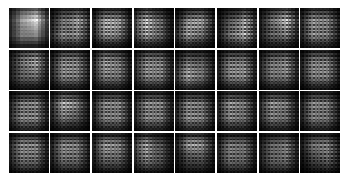

In [100]:
te = (save_gamma_1 != 0).float().permute(1, 0, 2, 3)
te = te.contiguous().view(128, -1).sum(dim=1)
val_sorted, idx_sorted = torch.sort(te, descending=True)

nb_dico_to_plot = 16
np.random.seed(6)
save_fig = False

dico = Net.layers[0].dico
selected_dico = np.random.choice(
    np.arange(dico.size()[0]), nb_dico_to_plot, replace=False)
dico = dico[selected_dico, :, :, :]

grid_param = {'padding': 1, 'normalize': True,
              'pad_value': 1,  'nrow': 8, 'scale_each': False}
to_show = show(make_grid(dico.clone().cpu(), **grid_param))
to_show.show()

if save_fig:
    save_image(make_grid(dico.clone().cpu(), **grid_param),
               path_saving + '/Fig2/Fig2b.png')

dico = Net.layers[0].backward(Net.layers[1].dico)
dico = dico[idx_sorted]
nb_dico_to_plot = 32
subsamp = torch.arange(0, 128, 4)

grid_param = {'padding': 1, 'normalize': True,
              'pad_value': 1,  'nrow': 8, 'scale_each': False}
to_show = show(make_grid(dico[subsamp].clone().cpu(), **grid_param))
to_show.show()

if save_fig:
    save_image(make_grid(dico[subsamp].clone().cpu(),
               **grid_param), path_saving + '/Fig2/Fig2d.png')
